# Fáza 3 - Strojové učenie (v 12. týždni): 20 bodov

__Autori:__ Dávid Penťa, Samuel Bernát
__Percentuálny podiel práce:__ 50% / 50%

Pri dátovej analýze nemusí byť naším cieľom získať len znalosti obsiahnuté v aktuálnych dátach, ale aj natrénovať model, ktorý bude schopný robiť rozumné predikcie pre nové pozorovania pomocou techniky strojového učenia.

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from IPython.display import HTML
from sklearn.svm import SVR
from sklearn.tree import export_graphviz
from graphviz import Source
from IPython.display import SVG
from sklearn.metrics import precision_recall_fscore_support, precision_score, recall_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel, VarianceThreshold, RFE
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

In [31]:
X_train = pd.read_csv('transformed_data/X_train.csv')
y_train = pd.read_csv('transformed_data/y_train.csv')
X_test = pd.read_csv('transformed_data/X_test.csv')
y_test = pd.read_csv('transformed_data/y_test.csv')
features = X_train.columns.values.tolist()
var_name = y_train.columns.values[0]

In [32]:
def oneRule_get_y(X, feature, split,  side1):

    y = pd.DataFrame(-1, index=range(X.shape[0]), columns=[var_name])

    if side1 == 1:
        side2 = 0
    else:
        side2 = 1

    y.loc[X[feature] < split, var_name] = side1
    y.loc[X[feature] >= split, var_name] = side2

    return y

In [33]:
def oneRule(X, y, feature, split, side1):
    pred_y = oneRule_get_y(X, feature, split,  side1)
    accuracy = accuracy_score(y[var_name], pred_y[var_name])
    precision = precision_score(y[var_name], pred_y[var_name])
    recall = recall_score(y[var_name], pred_y[var_name])

    return (accuracy + precision + recall) / 3


In [34]:
def oneRule_predict(X_, y_):
    oneR_X = X_.copy()
    oneR_y = y_.copy()

    best_side = 0
    best_split = 0
    best_feature = 0
    best_total = 0


    for feature in features:
        if feature != var_name:
            split = (oneR_X[feature][oneR_y[var_name] == 0].mean() + oneR_X[feature][oneR_y[var_name] == 1].mean()) / 2

            if oneR_X[feature][0] < split:
                if oneR_y[var_name][0] == 1:
                    side = 1
                else:
                    side = 0
            else:
                if oneR_y[var_name][0] == 1:
                    side = 0
                else:
                    side = 1

            total = oneRule(oneR_X, oneR_y, feature, split, side)
            if total > best_total:
                best_split = split
                best_feature = feature
                best_total = total
                best_side = side


    return [oneRule_get_y(oneR_X, best_feature, best_split, best_side), [best_feature, best_split, best_side]]

In [35]:
y_train_pred, oneR_model = oneRule_predict(X_train, y_train)
y_test_pred = oneRule_get_y(X_test, oneR_model[0], oneR_model[1], oneR_model[2])

train_accuracy = accuracy_score(y_train[var_name], y_train_pred[var_name])
train_precision = precision_score(y_train[var_name], y_train_pred[var_name])
train_recall = recall_score(y_train[var_name], y_train_pred[var_name])
train_total = (train_accuracy + train_precision + train_recall) / 3

test_accuracy = accuracy_score(y_test[var_name], y_test_pred[var_name])
test_precision = precision_score(y_test[var_name], y_test_pred[var_name])
test_recall = recall_score(y_test[var_name], y_test_pred[var_name])
test_total = (test_accuracy + test_precision + test_recall) / 3

print('Best feature: ' + oneR_model[0])
print('        accuracy   precision  recall     total')
print("Train   {:.8f} {:.8f} {:.8f} {:.8f}".format(*[train_accuracy, train_precision, train_recall, train_total]))
print("Test    {:.8f} {:.8f} {:.8f} {:.8f}".format(*[test_accuracy, test_precision, test_recall, test_total]))
print("Diff    {:.8f} {:.8f} {:.8f} {:.8f}".format(*[abs(test_accuracy-train_accuracy), abs(test_precision-train_precision), abs(test_recall-train_recall), abs(test_total-train_total)]))

Best feature: PAHs
        accuracy   precision  recall     total
Train   0.83132838 0.88667292 0.81902904 0.84567678
Test    0.82921028 0.89620584 0.81065089 0.84535567
Diff    0.00211811 0.00953292 0.00837815 0.00032111


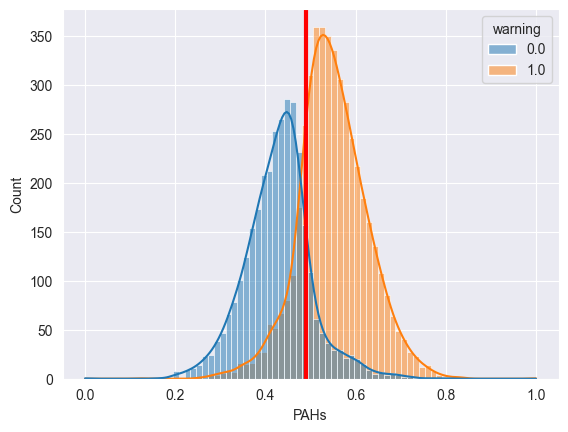

In [36]:
sns.histplot(data=X_train, hue=y_train[var_name] , x=oneR_model[0], fill=True, kde=True)
plt.axvline(oneR_model[1], linewidth=3, color='r')
plt.show()

jednoduche ale slabe

## Trénovanie a vyhodnotenie klasifikátorov strojového učenia (5b)
- Na trénovanie využite minimálne jeden stromový algoritmus strojového učenia v scikit-learn.
- Vizualizujte natrénované pravidlá.
- Vyhodnoťte natrénované modely pomocou metrík accuracy, precision a recall
- Porovnajte aspoň jeden natrénovaný klasifikátor v scikit-learn s jednoduchým klasifikátorom
z prvého kroku.


In [37]:
from sklearn.metrics import confusion_matrix, classification_report


def print_accuracy_precision_recall_total(model, X_train_, X_test_, y_train_, y_test_):
    y_train_pred_arr = model.predict(X_train_)
    y_test_pred_arr = model.predict(X_test_)

    y_train_pred = pd.DataFrame({var_name: y_train_pred_arr.ravel()})
    y_test_pred = pd.DataFrame({var_name: y_test_pred_arr.ravel()})

    train_accuracy = accuracy_score(y_train_[var_name], y_train_pred[var_name])
    train_precision = precision_score(y_train_[var_name], y_train_pred[var_name])
    train_recall = recall_score(y_train_[var_name], y_train_pred[var_name])
    train_total = (train_accuracy + train_precision + train_recall) / 3

    test_accuracy = accuracy_score(y_test_[var_name], y_test_pred[var_name])
    test_precision = precision_score(y_test_[var_name], y_test_pred[var_name])
    test_recall = recall_score(y_test_[var_name], y_test_pred[var_name])
    test_total = (test_accuracy + test_precision + test_recall) / 3

    print('        accuracy   precision  recall     total')
    print("Train   {:.8f} {:.8f} {:.8f} {:.8f}".format(*[train_accuracy, train_precision, train_recall, train_total]))
    print("Test    {:.8f} {:.8f} {:.8f} {:.8f}".format(*[test_accuracy, test_precision, test_recall, test_total]))
    print("Diff    {:.8f} {:.8f} {:.8f} {:.8f}".format(*[abs(test_accuracy-train_accuracy), abs(test_precision-train_precision), abs(test_recall-train_recall), abs(test_total-train_total)]))

    print('Train')
    mat = confusion_matrix(y_train, y_train_pred)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
    plt.xlabel('real')
    plt.ylabel('predicted')
    plt.show()
    print(classification_report(y_train, y_train_pred, target_names = ["0","1"]))

    print('Test')
    mat = confusion_matrix(y_test, y_test_pred)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
    plt.xlabel('real')
    plt.ylabel('predicted')
    plt.show()

    print(classification_report(y_test, y_test_pred, target_names = ["0","1"]))

### Decision tree classifier

In [38]:
dt = tree.DecisionTreeClassifier()
dt = dt.fit(X_train, y_train)

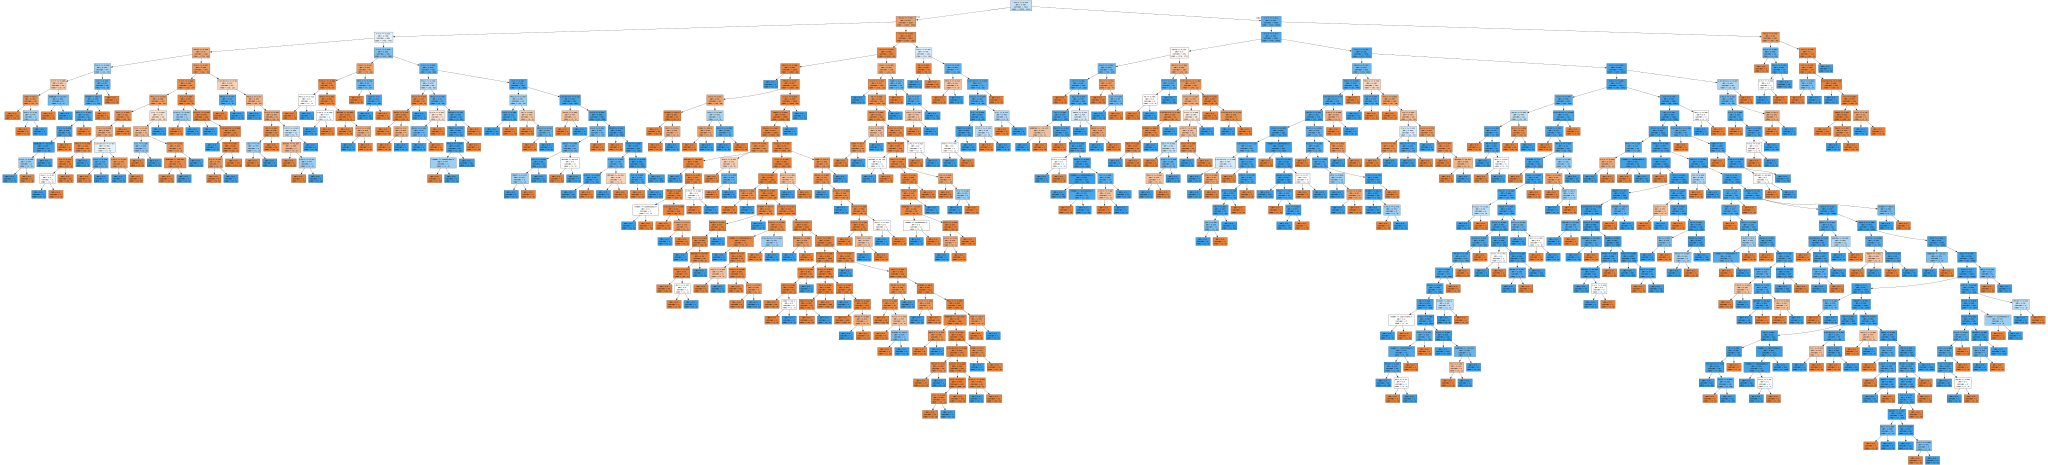

In [39]:
graph = Source(export_graphviz(dt,
                               out_file=None,
                               feature_names=features,
                               filled = True))

display(SVG(graph.pipe(format='svg')))

style = "<style>svg{width:100% !important;height:100% !important;}</style>"
HTML(style)

        accuracy   precision  recall     total
Train   1.00000000 1.00000000 1.00000000 1.00000000
Test    0.90033302 0.92320000 0.91045365 0.91132889
Diff    0.09966698 0.07680000 0.08954635 0.08867111
Train


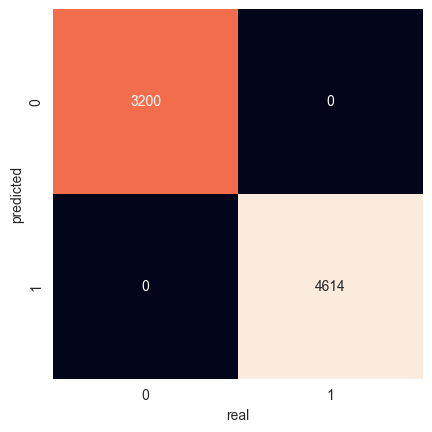

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3200
           1       1.00      1.00      1.00      4614

    accuracy                           1.00      7814
   macro avg       1.00      1.00      1.00      7814
weighted avg       1.00      1.00      1.00      7814

Test


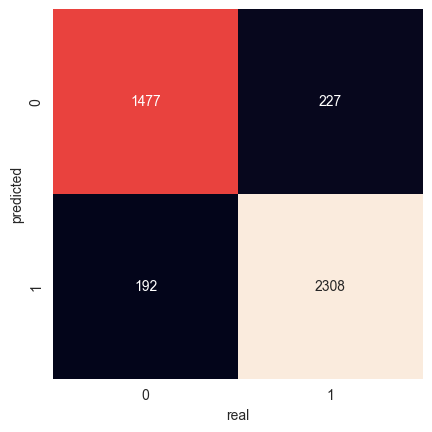

              precision    recall  f1-score   support

           0       0.87      0.88      0.88      1669
           1       0.92      0.91      0.92      2535

    accuracy                           0.90      4204
   macro avg       0.89      0.90      0.90      4204
weighted avg       0.90      0.90      0.90      4204



In [40]:
print_accuracy_precision_recall_total(dt, X_train, X_test, y_train, y_test)

mega overfitting

### Random forest classifier

In [41]:
rf = RandomForestClassifier()
rf = rf.fit(X_train, np.ravel(y_train))
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

        accuracy   precision  recall     total
Train   1.00000000 1.00000000 1.00000000 1.00000000
Test    0.95099905 0.95364238 0.96568047 0.95677397
Diff    0.04900095 0.04635762 0.03431953 0.04322603
Train


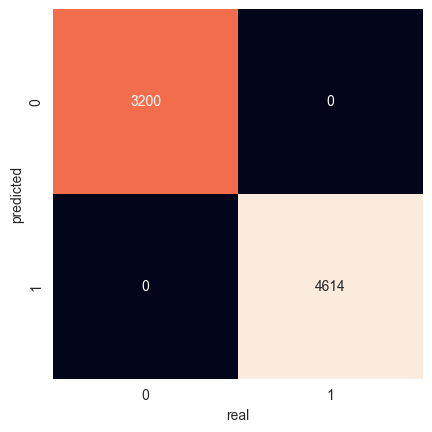

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3200
           1       1.00      1.00      1.00      4614

    accuracy                           1.00      7814
   macro avg       1.00      1.00      1.00      7814
weighted avg       1.00      1.00      1.00      7814

Test


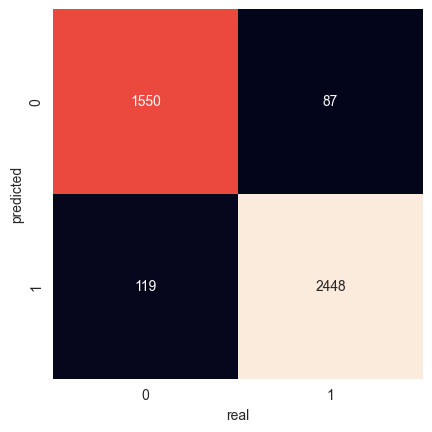

              precision    recall  f1-score   support

           0       0.95      0.93      0.94      1669
           1       0.95      0.97      0.96      2535

    accuracy                           0.95      4204
   macro avg       0.95      0.95      0.95      4204
weighted avg       0.95      0.95      0.95      4204



In [42]:
print_accuracy_precision_recall_total(rf, X_train, X_test, y_train, y_test)

tiez ma overfit

## Optimalizácia alias hyperparameter tuning (5b)
- Preskúmajte hyperparametre Vášho zvoleného klasifikačného algoritmu v druhom kroku a vyskúšajte ich rôzne nastavenie tak, aby ste minimalizovali overfitting (preučenie) a optimalizovali výsledok.
- Vysvetlite, čo jednotlivé hyperparametre robia. Pri nastavovaní hyperparametrov algoritmu využite krížovú validáciu (cross validation) na trénovacej množine.

### Výber atribútov pre strojové učenie

In [43]:
clf = RandomForestClassifier()
clf = clf.fit(X_train, np.ravel(y_train))
model = SelectFromModel(clf, prefit=True)
feature_idx = model.get_support()
informative_features = X_train.columns[feature_idx]
informative_features

Index(['PM10', 'C2H3NO5', 'NH3', 'CH4', 'PAHs'], dtype='object')

In [44]:
X_train_info = X_train[informative_features].copy()
X_test_info = X_test[informative_features].copy()

### Decision tree classifier

Fitting 4 folds for each of 960 candidates, totalling 3840 fits
{'criterion': 'entropy', 'max_depth': 40, 'min_samples_leaf': 10, 'min_samples_split': 5, 'splitter': 'best'}
        accuracy   precision  recall     total
Train   0.95060148 0.95267666 0.96423927 0.95583914
Test    0.93696480 0.94579733 0.94990138 0.94422117
Diff    0.01363669 0.00687933 0.01433789 0.01161797
Train


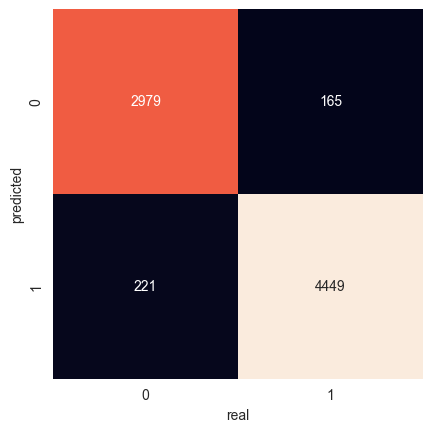

              precision    recall  f1-score   support

           0       0.95      0.93      0.94      3200
           1       0.95      0.96      0.96      4614

    accuracy                           0.95      7814
   macro avg       0.95      0.95      0.95      7814
weighted avg       0.95      0.95      0.95      7814

Test


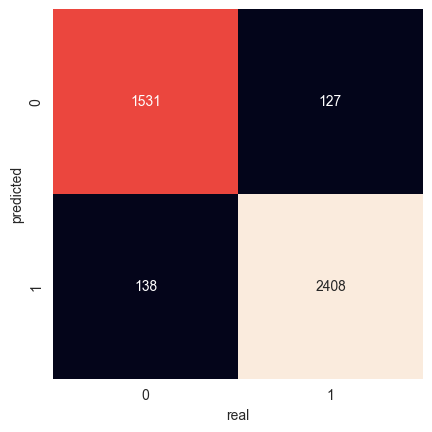

              precision    recall  f1-score   support

           0       0.92      0.92      0.92      1669
           1       0.95      0.95      0.95      2535

    accuracy                           0.94      4204
   macro avg       0.93      0.93      0.93      4204
weighted avg       0.94      0.94      0.94      4204



In [45]:
# grid search
max_depth = [5, 8, 10, 15, 20, 30, 40, 50]
min_samples_split = [2, 5, 10, 15, 20]
min_samples_leaf = [1, 2, 5, 10]
criterion = ["gini", "entropy", "log_loss"]
splitter = ["best", "random"]

dt = tree.DecisionTreeClassifier()

hyper = dict(max_depth = max_depth,
             splitter=splitter,
             min_samples_split = min_samples_split,
             min_samples_leaf = min_samples_leaf,
             criterion = criterion)

gs_dt = GridSearchCV(estimator=dt, param_grid=hyper, cv=4, verbose=1, n_jobs=-1)
gs_dt = gs_dt.fit(X_train_info, np.ravel(y_train))
print(gs_dt.best_params_)
print_accuracy_precision_recall_total(gs_dt.best_estimator_, X_train_info, X_test_info, y_train, y_test)

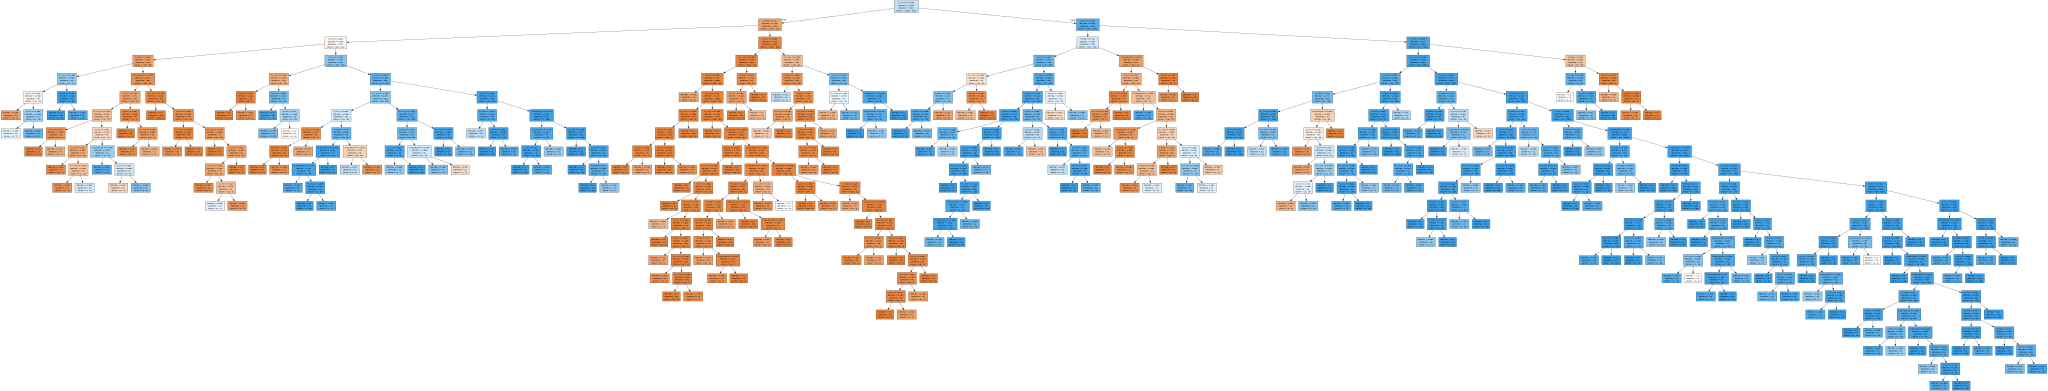

In [46]:
graph = Source(export_graphviz(gs_dt.best_estimator_,
                               out_file=None,
                               feature_names=informative_features,
                               filled = True))

display(SVG(graph.pipe(format='svg')))

style = "<style>svg{width:100% !important;height:100% !important;}</style>"
HTML(style)

In [47]:
X_train1, X_train2, y_train1, y_train2 = train_test_split(X_train_info, y_train)

In [48]:
# path pruning
tr = gs_dt.best_estimator_

path = tr.cost_complexity_pruning_path(X_train1, y_train1)

alphas = path.ccp_alphas
clfs = []

for alpha in alphas:
    clf = tree.DecisionTreeClassifier(ccp_alpha=alpha)
    clf.fit(X_train1, y_train1)
    clfs.append(clf)

train_scores = [clf.score(X_train2, y_train2) for clf in clfs]
index_best_model = np.argmax(train_scores)

best_model = clfs[index_best_model]

        accuracy   precision  recall     total
Train   0.95290504 0.95382642 0.96705678 0.95792942
Test    0.93767840 0.94656189 0.95029586 0.94484538
Diff    0.01522664 0.00726454 0.01676093 0.01308403
Train


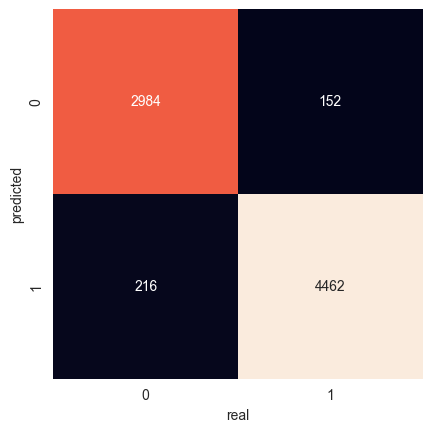

              precision    recall  f1-score   support

           0       0.95      0.93      0.94      3200
           1       0.95      0.97      0.96      4614

    accuracy                           0.95      7814
   macro avg       0.95      0.95      0.95      7814
weighted avg       0.95      0.95      0.95      7814

Test


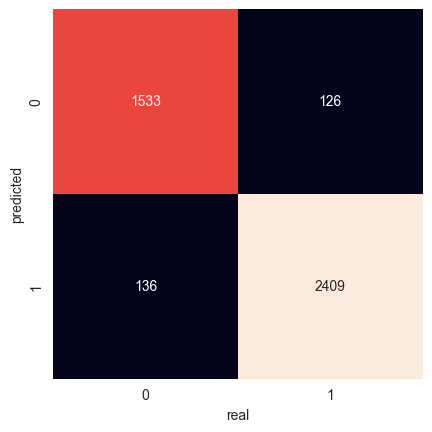

              precision    recall  f1-score   support

           0       0.92      0.92      0.92      1669
           1       0.95      0.95      0.95      2535

    accuracy                           0.94      4204
   macro avg       0.94      0.93      0.93      4204
weighted avg       0.94      0.94      0.94      4204



In [49]:
print_accuracy_precision_recall_total(best_model, X_train_info, X_test_info, y_train, y_test)

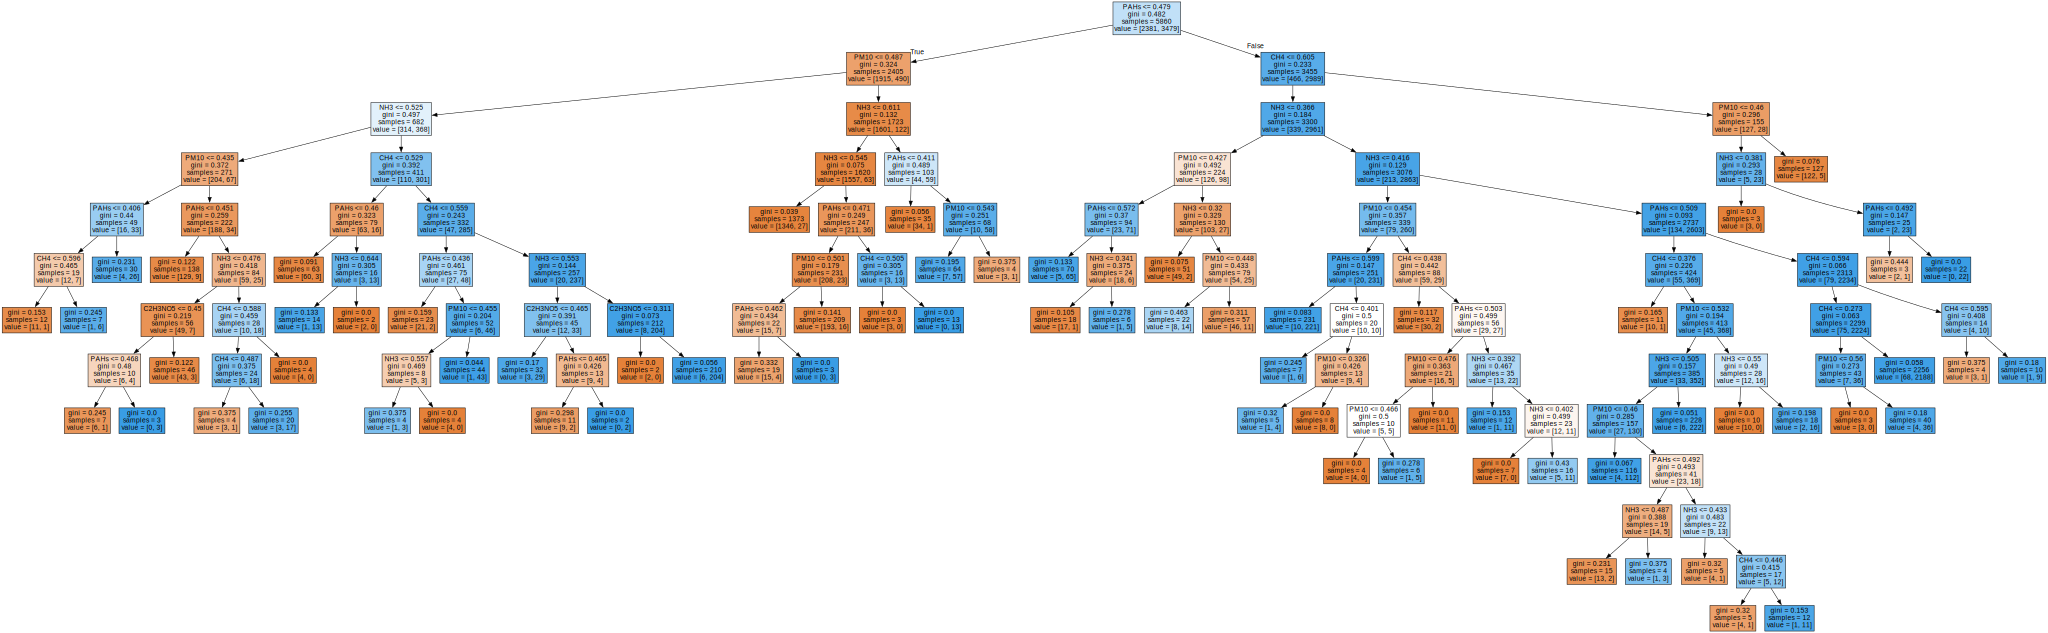

In [50]:
graph = Source(export_graphviz(best_model,
                               out_file=None,
                               feature_names=informative_features,
                               filled = True))

display(SVG(graph.pipe(format='svg')))

style = "<style>svg{width:100% !important;height:100% !important;}</style>"
HTML(style)

## Vyhodnotenie vplyvu zvolenej stratégie riešenia na klasifikáciu (5b)
Vyhodnotíte Vami zvolené stratégie riešenia projektu z hľadiska classification accuracy:
- Stratégie riešenia chýbajúcich hodnôt a outlierov;
- Scaling resp. transformer či zlepší accuracy klasifikácie;
- Výber atribútov a výber algoritmov strojového učenia;
- Hyperparameter tuning resp. ensemble learning.
Ktoré spôsoby z hore-uvedených bodov sa ukázali ako učinné pre Váš dataset? Hodnotenie podložíte dôkazmi.

### Stratégie riešenia chýbajúcich hodnôt a outlierov

### Scaling resp. transformer či zlepší accuracy klasifikácie

### Výber atribútov a výber algoritmov strojového učenia

In [51]:
# # Recursive feature elimination (RFE)
# estimator = SVR(kernel="linear")
# selector = RFE(estimator, n_features_to_select=5, step=1)
# selector = selector.fit(X_train, y_train)
#
# print(selector.support_)
# print(selector.ranking_)
#
# # Feature selection using SelectFromModel
# selector = SelectFromModel(estimator=LogisticRegression()).fit(X_train, y_train)
# print(selector.estimator_.coef_)
# print(selector.threshold_)
# print(selector.get_support())

### Hyperparameter tuning resp. ensemble learning

In [85]:
# path pruning
# grid search